In [111]:
import sys
import os

project_root = os.path.abspath('..')
if project_root not in sys.path:
    sys.path.append(project_root)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [112]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings

from src.features import build_features

warnings.filterwarnings("ignore")
sns.set_style()
plt.rcParams["figure.figsize"] = (12, 6)

# Lectura de bases de datos

En este análisis se utilizarán 2 bases de datos:

- Base de datos de consultas ambulatorias INT
- Base de datos de procedimientos ambulatorios INT

Ambas bases de datos tienen fechas distintas. 

In [113]:
cie = pd.read_excel("../data/external/CIE-10 - sin_puntos_y_X.xlsx")

In [114]:
df_diagnosticos = pd.read_csv(
    "../data/processed/datos_limpios_diagnosticos.csv", encoding="latin-1", sep=";"
)
df_diagnosticos = build_features.formatear_fechas_ambulatorio(df_diagnosticos)
df_diagnosticos = build_features.agregar_rango_etario(df_diagnosticos)
df_diagnosticos = build_features.agregar_anio_mes_dia(df_diagnosticos, "fecha_atencion")
df_diagnosticos = df_diagnosticos.sort_values("fecha_atencion")

In [115]:
df_procedimientos = pd.read_csv(
    "../data/processed/datos_limpios_procedimientos.csv", encoding="latin-1", sep=";"
)
df_procedimientos = build_features.formatear_fechas_procedimientos(df_procedimientos)
df_procedimientos = build_features.agregar_anio_mes_dia(df_procedimientos, "fecha_realizacion")
df_procedimientos = df_procedimientos.sort_values("fecha_realizacion")

cols_texto = df_procedimientos.select_dtypes(include="object").apply(lambda x: x.str.strip())
df_procedimientos.loc[:, cols_texto.columns] = cols_texto

## 1. Analisis de cantidad de consultas y procedimientos

En este apartado se quieren responder las siguientes preguntas:

- ¿Cuál es el rango temporal en la que están ambas bases de datos analizadas?
- ¿Cuántas consultas hay?
- ¿Cuántos procedimientos hay?

El rango de fechas de diagnosticos es entre 2016-01-04 08:00:00 y  2023-02-07 11:50:03
El rango de fechas de procedimientos es entre 2020-01-02 00:00:00 y  2022-08-31 00:00:00

La base de datos de diagnosticos tiene 265441 consultas
La base de datos de procedimientos tiene 39484 procedimientos


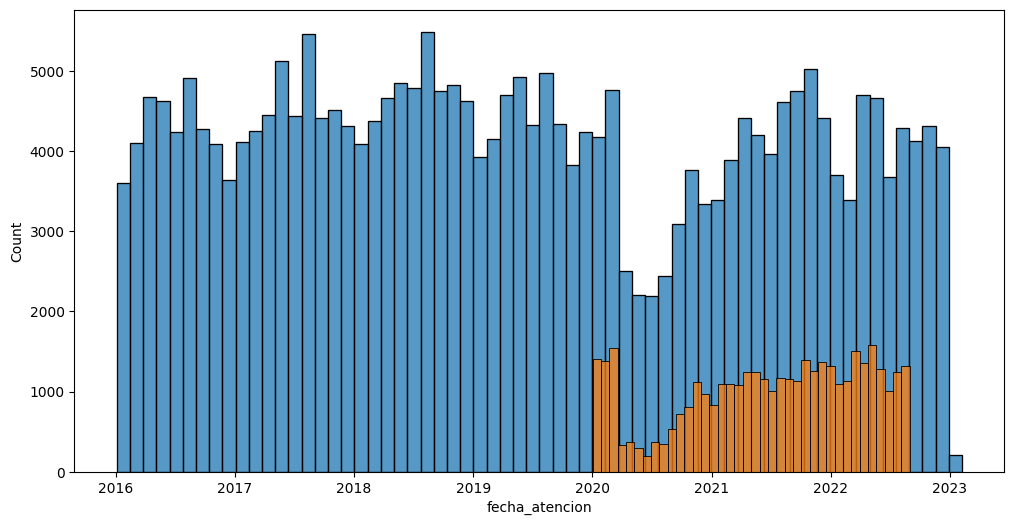

In [116]:
fecha_min_diags = min(df_diagnosticos.fecha_atencion)
fecha_max_diags = max(df_diagnosticos.fecha_atencion)

fecha_min_proced = min(df_procedimientos.fecha_realizacion)
fecha_max_proced = max(df_procedimientos.fecha_realizacion)

print(f"El rango de fechas de diagnosticos es entre {fecha_min_diags} y " f" {fecha_max_diags}")
print(f"El rango de fechas de procedimientos es entre {fecha_min_proced} y " f" {fecha_max_proced}")

print(f"\nLa base de datos de diagnosticos tiene {df_diagnosticos.shape[0]} consultas")
print(f"La base de datos de procedimientos tiene {df_procedimientos.shape[0]} procedimientos")

sns.histplot(df_diagnosticos["fecha_atencion"])
sns.histplot(df_procedimientos["fecha_realizacion"])
plt.show()

Los resultados anteriores indican que ambas bases están en rangos temporales distintos. Sin embargo,
la base de procedimientos está contenida temporalmente en la base de consultas ambulatorias.

Para efectos comparativos, se filtrará la base de consultas ambulatorias para que esté en el mismo
rango temporal que la base de procedimientos.

In [117]:
mask_fechas = (df_diagnosticos["fecha_atencion"] >= fecha_min_proced) & (
    df_diagnosticos["fecha_atencion"] <= fecha_max_proced
)

df_diagnosticos_acotado = df_diagnosticos[mask_fechas]

El rango de fechas de diagnosticos acotado es entre 2020-01-02 08:00:00 y  2022-08-30 18:02:43
La base de diagnosticos acotados tiene 91916 consultas


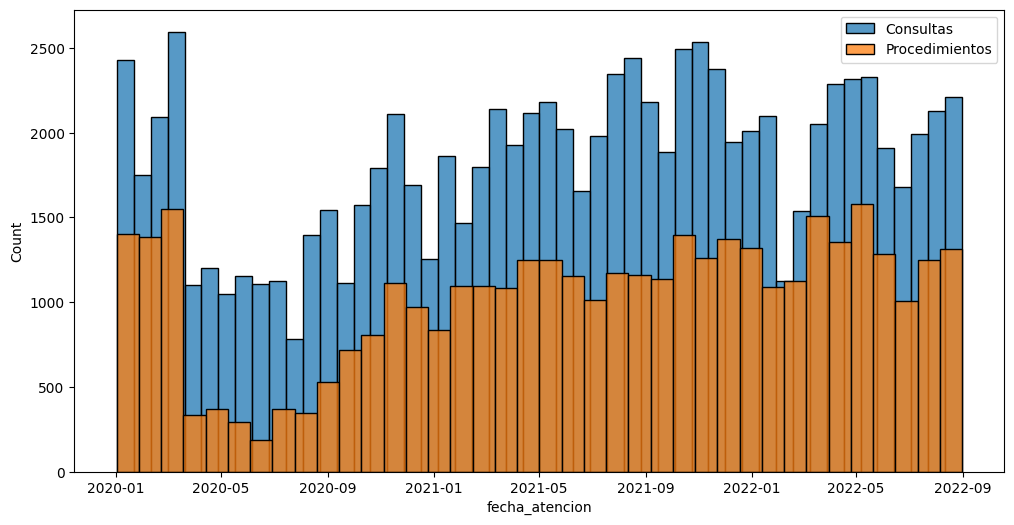

In [118]:
fecha_min_diags_acotada = min(df_diagnosticos_acotado.fecha_atencion)
fecha_max_diags_acotada = max(df_diagnosticos_acotado.fecha_atencion)

print(
    f"El rango de fechas de diagnosticos acotado es entre {fecha_min_diags_acotada} y "
    f" {fecha_max_diags_acotada}"
)

print(f"La base de diagnosticos acotados tiene {df_diagnosticos_acotado.shape[0]} consultas")

sns.histplot(df_diagnosticos_acotado["fecha_atencion"], label="Consultas")
sns.histplot(df_procedimientos["fecha_realizacion"], label="Procedimientos")
plt.legend()
plt.show()

Con el filtro aplicado se observa que ambas bases se encuentran en el mismo periodo temporal.
Finalmente, en ambas bases se eliminarán los registros que carezcan de una fecha de procedimiento.

In [119]:
df_diagnosticos_acotado = df_diagnosticos_acotado.dropna(subset="fecha_atencion")
df_procedimientos = df_procedimientos.dropna(subset="fecha_realizacion")

print(f"La base de datos de consultas acotada tiene {df_diagnosticos_acotado.shape[0]} consultas")
print(f"La base de datos de procedimeintos tiene {df_procedimientos.shape[0]} procedimientos")

La base de datos de consultas acotada tiene 91916 consultas
La base de datos de procedimeintos tiene 39472 procedimientos


Por lo tanto, ambas bases se dejaron en un mismo rango temporal. La base de diagnósticos quedó
con 91916 consultas (de 265441, diferencia de 173525), y la base de procedimientos con 39472 (de 39484, 
diferencia de 12).

## 2. Análisis Sociodemografico a lo largo del tiempo

En este analisis se quieren responder las siguientes preguntas:

1. ¿Cuántas consultas hay por año?
2. ¿Cuáles son los diagnósticos más frecuentes por año?
3. ¿Cuál es el **rango etario** de las personas que se atienden ambulatoriamente en el Hospital del
Tórax? ¿Cómo cambia este perfil por cada uno de los diagnóstico?
4. ¿Cuál es el **género/sexo** de las personas que se atienden ambulatoriamente en el Hospital del
Tórax? ¿Cómo cambia este perfil por cada uno de los diagnósticos?
5. ¿Cuál es la **previsión** de las personas que se atienden ambulatoriamente en el Hospital del
Tórax? ¿Cómo cambia este perfil por cada uno de los diagnósticos?
6. ¿Cuál es el **servicio de salud** de las personas que se atienden ambulatoriamente en el Hospital del
Tórax? ¿Cómo cambia este perfil por cada uno de los diagnósticos?
7. ¿Cuál es la **comuna** de las personas que se atienden ambulatoriamente en el Hospital del
Tórax? ¿Cómo cambia este perfil por cada uno de los diagnósticos?

Para responder estas preguntas se utilizará la base de datos de consultas ambulatorias
del sistema HIS del Instituto Nacional del Tórax. La base de datos contiene consultas desde
el año 2016 al 2022. Esta base contiene los datos para saber la frecuencia por diagnóstico,
rango etario y género.

A pesar de lo anterior, la base de datos de consultas carece de los últimos 3 datos a analizar
(previsón, servicio de salud y comuna de residencia). Debido a esta razón, se utilizará la base
de datos estadística/procedimientos para extraer estos datos.

Producto de lo anterior, surgen las siguientes consideración a tener:

1. ¿Qué pasa si es que un paciente se cambió de comuna/previsión/servicio de salud?
2. ¿Qué ocurre con los pacientes que tienen una consulta, pero que jamás se hayan hecho un
procedimiento?
3. ¿Qué ocurre con los pacientes que tienen un procedimiento, pero que jamás se hayan hecho
una consulta?

Debido a lo anterior, es necesario validar ciertos puntos de las bases de datos.

### 2.1 Obtención de datos de comuna/previsión/servicio de salud por paciente

Estos datos se pueden obtener desde la base de datos de procedimientos/datos estadísticos del
INT. El único detalle que puede existir al extraer estos datos es:

- **¿Qué pasa si un paciente se cambió de comuna/previsión/servicio de salud?**

Para abordar tal detalle, se elegirá el primer registro del paciente en la base de datos (el más
antiguo)

In [120]:
df_procedimientos = df_procedimientos.sort_values("fecha_realizacion")
display(df_procedimientos.fecha_realizacion)

18599   2020-01-02
418     2020-01-02
26452   2020-01-02
417     2020-01-02
18602   2020-01-02
           ...    
18001   2022-08-31
18547   2022-08-31
33341   2022-08-31
18561   2022-08-31
20706   2022-08-31
Name: fecha_realizacion, Length: 39472, dtype: datetime64[ns]

Los datos anteriores indican que las fechas de los procedimientos se encuentran ordenados
de forma ascendente. Además, existen 39472 procedimientos realizados.

Con este control de calidad ya realizado, es posible extraer los datos de pacientes únicos.

In [121]:
datos_pacientes = (
    df_procedimientos.value_counts(
        ["id_paciente", "comuna_residencia", "prevision", "servicio_salud"]
    )
    .reset_index()
    .drop(columns="count")
)

indices_pacientes_unicos = datos_pacientes.groupby("id_paciente").head(1).index
pacientes_unicos = datos_pacientes.iloc[indices_pacientes_unicos]

In [122]:
print(
    f"La cantidad de pacientes repetidos en los datos unicos son: "
    f"{pacientes_unicos.id_paciente.duplicated().sum()}"
)

La cantidad de pacientes repetidos en los datos unicos son: 0


Una vez sabiendo que sólamente existen datos únicos para los pacientes, entonces estos se pueden
unir a la base de datos de consultas. Sin embargo, debemos saber cuántos de los pacientes que se
han realizado un procedimiento se han realizado una consulta.

In [123]:
pacientes_unicos_consulta = set(df_diagnosticos_acotado.id_paciente.unique())
pacientes_unicos_procedimientos = set(pacientes_unicos.id_paciente.unique())

diferencia_pacientes_consultas = pacientes_unicos_consulta - pacientes_unicos_procedimientos
diferencia_pacientes_procedimientos = pacientes_unicos_procedimientos - pacientes_unicos_consulta
pacientes_en_ambas = pacientes_unicos_consulta & pacientes_unicos_procedimientos

print(f"> La base de consultas tiene {len(pacientes_unicos_consulta)} pacientes distintos")
print(
    f"> La base de procedimientos tiene {len(pacientes_unicos_procedimientos)} pacientes distintos\n"
)
print(
    f"> Hay una diferencia de {len(diferencia_pacientes_consultas)} pacientes que solo estan "
    f"en las consultas"
)
print(
    f"> Hay una diferencia de {len(diferencia_pacientes_procedimientos)} pacientes que solo estan"
    f" en procedimientos\n"
)
print(f"> Hay {len(pacientes_en_ambas)} pacientes que estan en ambas bases de datos")

> La base de consultas tiene 23213 pacientes distintos
> La base de procedimientos tiene 13826 pacientes distintos

> Hay una diferencia de 11482 pacientes que solo estan en las consultas
> Hay una diferencia de 2095 pacientes que solo estan en procedimientos

> Hay 11731 pacientes que estan en ambas bases de datos


In [124]:
df_diagnosticos_datos_paciente = pd.merge(
    df_diagnosticos, pacientes_unicos, how="left", on="id_paciente"
)

In [125]:
consultas_sin_prevision = df_diagnosticos_datos_paciente.prevision.isna().sum()
consultas_totales = df_diagnosticos_datos_paciente.shape[0]
porcentaje_sin_prevision = consultas_sin_prevision / consultas_totales

print(
    f"Hay {consultas_sin_prevision} de {consultas_totales} ({porcentaje_sin_prevision:.2f}) "
    f"consultas que quedaron sin una prevision asignada"
)

Hay 144230 de 265441 (0.54) consultas que quedaron sin una prevision asignada


Una vez se ha obtenido la mayor cantidad de información sociodemográfica de los pacientes (rango
etario, género, previsión, servicio de salud y comuna), se debe obtener el desglose por cada
una de estas variables.

### 2.2 Obtención de desglose sociodemográfico de consultas

En el apartado anterior obtuvimos los datos sociodemográficos (previsión, servicio de salud y comuna) 
de los pacientes de consultas utilizando la base de datos de procedimientos ambulatorios. Esto 
permitió asignar tales datos al 46% de las consultas totales (entre 2016 y 2022).

Teniendo la anterior, se procederá a obtener las tablas con el desglose por cada una de las variables
sociodemográficas.

Además, se filtrará la base de datos de consultas ambulatorias dejando solamente los diagnósticos
que tengan códigos CIE-10 válidos (que el código tenga un largo 4).

In [126]:
agrupacion_estatica = ["ano"]
variable_a_contar = "codigo_diagnostico"

vars_a_obtener_detalle = [
    "sexo",
    "rango_etario_primera_consulta",
    "comuna_residencia",
    "prevision",
    "servicio_salud",
]

df_diagnosticos_largo_4 = df_diagnosticos_datos_paciente[
    df_diagnosticos_datos_paciente.codigo_diagnostico.str.len() == 4
]

resultado_sociodemo = build_features.obtener_desglose_sociodemografico(
    df_diagnosticos_largo_4,
    agrupacion_estatica,
    vars_a_obtener_detalle,
    variable_a_contar,
)

resultado_sociodemo["global"] = build_features.leer_cie_y_unir_a_datos(
    resultado_sociodemo["global"], "codigo_diagnostico"
)

ruta_a_guardar = "../data/interim/tableros_powerbi/distribucion_sociodemografica.xlsx"

with pd.ExcelWriter(ruta_a_guardar) as file:
    for nombre_hoja, df_a_guardar in resultado_sociodemo.items():
        df_a_guardar.to_excel(file, sheet_name=nombre_hoja, index=False)

### 2.3 Obtención de insights más importantes de consultas

Una vez exportado el análisis se pueden responder las preguntas planteadas al inicio de la
sección.

In [127]:
cantidad_consultas_por_anio = resultado_sociodemo["global"].groupby("ano")["conteo_global"].sum()
diags_mas_frecuentes_por_anio = (
    resultado_sociodemo["global"].groupby("ano").head(20)["codigo_diagnostico"].unique()
)

print(f"La cantidad de consultas en la base de datos es: \n{cantidad_consultas_por_anio}\n")
print(f"Los diagnosticos mas frecuentes son: \n{diags_mas_frecuentes_por_anio}")

La cantidad de consultas en la base de datos es: 
ano
2016    37710
2017    40112
2018    41242
2019    38440
2020    27846
2021    37365
2022    35490
2023        4
Name: conteo_global, dtype: int64

Los diagnosticos mas frecuentes son: 
['C34X' 'J841' 'G473' 'J450' 'I99X' 'J47X' 'J849' 'J449' 'C349' 'J848'
 'J84X' 'I50X' 'F17X' 'C341' 'I441' 'I498' 'J459' 'R91X' 'I49X' 'D381'
 'I459' 'XXXX' 'I350' 'J432' 'I255' 'Q208' 'Z942' 'C340' 'J67X' 'E849'
 'R060' 'Z941']


A modo de control, se contrastará la base de datos de consultas con la base de datos REM (REM07 (Consultas Medicas) + REM32 (Consultas Medicas Telefonicas)). Esto, ya que permite ver que tan fidedigna
es la base de datos ambulatoria. La base de datos REM tiene la siguiente cantidad de consultas:

In [128]:
resumen_rem = pd.read_csv("../data/external/resumen_datos_rem.csv").set_index("year")
display(resumen_rem)

,Consultas Medicas Presenciales,Consultas Medicas Telefonicas,Total
year,,,
2016,34149,NaN,34149
2017,33078,NaN,33078
2018,32806,NaN,32806
2019,36084,NaN,36084
2020,14109,13617.0,27726
2021,25715,6418.0,32133


La comparacion de la base de datos con REM es: 
   year  consultas_bd  consultas_rem   dif
0  2016         37710          34149  3561
1  2017         40112          33078  7034
2  2018         41242          32806  8436
3  2019         38440          36084  2356
4  2020         27846          27726   120
5  2021         37365          32133  5232

Hay una diferencia promedio de 4456 consultas entre la base de datos y REM, con un minimo de 120 y un maximo de 8436 consultas. La distribucion de la diferencia entre ambas bases es:


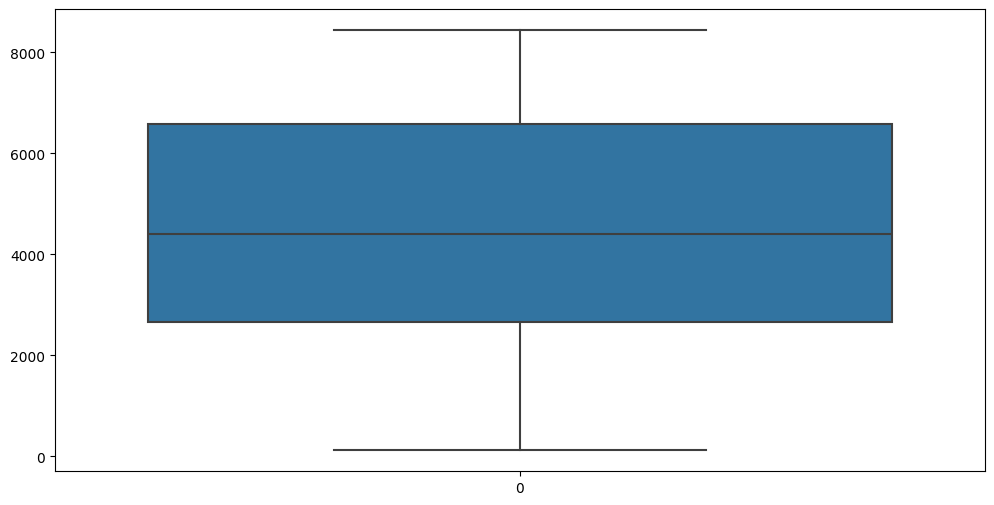

In [129]:
comparacion_bd_rem = (
    pd.merge(cantidad_consultas_por_anio, resumen_rem, left_index=True, right_index=True)
    .iloc[:, [0, -1]]
    .reset_index()
)

comparacion_bd_rem.columns = ["year", "consultas_bd", "consultas_rem"]
comparacion_bd_rem["dif"] = comparacion_bd_rem.consultas_bd - comparacion_bd_rem.consultas_rem

promedio_diferencias_bd_rem = comparacion_bd_rem.dif.mean()
minimo_diferencias_bd_rem = comparacion_bd_rem.dif.min()
maximo_diferencias_bd_rem = comparacion_bd_rem.dif.max()

print(f"La comparacion de la base de datos con REM es: \n{comparacion_bd_rem}\n")
print(
    f"Hay una diferencia promedio de {promedio_diferencias_bd_rem:.0f} consultas entre la base "
    f"de datos y REM, con un minimo de {minimo_diferencias_bd_rem} y un maximo de "
    f"{maximo_diferencias_bd_rem} consultas. La distribucion de la diferencia entre ambas "
    f"bases es:"
)

sns.boxplot(comparacion_bd_rem["dif"])
plt.show()

## Diagnosticos mas relevantes entre 2016 y 2023

Posteriormemnte, se quieren seleccionar los 20 diagnósticos más frecuentes para cada uno de los
años. Luego, se generará una lista conteniendo solamente los diagnósticos únicos de las listas
anteriores.

In [130]:
diags_mas_relevantes = (
    resultado_sociodemo["global"].groupby("ano").head(20).codigo_diagnostico.unique()
)
consultas_totales_mas_relevantes = resultado_sociodemo["global"][
    resultado_sociodemo["global"]["codigo_diagnostico"].isin(diags_mas_relevantes)
]

In [131]:
print(
    f"Los diagnosticos más relevantes para el Hospital del Tórax en el ámbito ambulatorio"
    f" son: \n{diags_mas_relevantes}"
)

print(f"> {len(diags_mas_relevantes)} diagnosticos")

Los diagnosticos más relevantes para el Hospital del Tórax en el ámbito ambulatorio son: 
['C34X' 'J841' 'G473' 'J450' 'I99X' 'J47X' 'J849' 'J449' 'C349' 'J848'
 'J84X' 'I50X' 'F17X' 'C341' 'I441' 'I498' 'J459' 'R91X' 'I49X' 'D381'
 'I459' 'XXXX' 'I350' 'J432' 'I255' 'Q208' 'Z942' 'C340' 'J67X' 'E849'
 'R060' 'Z941']
> 32 diagnosticos


In [132]:
resumen_consultas_mas_relevantes = pd.pivot_table(
    consultas_totales_mas_relevantes,
    values="conteo_global",
    index=["codigo_diagnostico", "Descripción"],
    columns="ano",
    aggfunc=np.sum,
)

resumen_consultas_totales = pd.pivot_table(
    resultado_sociodemo["global"],
    values="conteo_global",
    index=["codigo_diagnostico", "Descripción"],
    columns="ano",
    aggfunc=np.sum,
)

comparacion_total_mas_relevantes = pd.concat(
    [resumen_consultas_mas_relevantes.sum(), resumen_consultas_totales.sum()],
    axis=1,
    keys=["Mas Relevantes", "Totales"],
)
comparacion_total_mas_relevantes["porcentaje_del_total"] = (
    comparacion_total_mas_relevantes["Mas Relevantes"] / comparacion_total_mas_relevantes["Totales"]
)

diccionario_resultado = {
    "diagnosticos_mas_relevantes": resumen_consultas_mas_relevantes,
    "comparacion_del_total": comparacion_total_mas_relevantes,
    "totales": resumen_consultas_totales,
    "BD_mas_relevantes": consultas_totales_mas_relevantes,
}

with pd.ExcelWriter("../data/interim/diagnosticos_mas_relevantes_ambulatorios.xlsx") as file:
    for nombre_hoja, df_a_guardar in diccionario_resultado.items():
        df_a_guardar.to_excel(file, sheet_name=nombre_hoja)

In [133]:
display(comparacion_total_mas_relevantes)
display(resultado_sociodemo["global"].groupby("ano")["codigo_diagnostico"].nunique())

,Mas Relevantes,Totales,porcentaje_del_total
ano,,,
2016,23868.0,37578.0,0.635159
2017,25690.0,40039.0,0.641624
2018,27511.0,41194.0,0.667840
2019,25506.0,38401.0,0.664201
2020,18320.0,27798.0,0.659040
2021,25008.0,37320.0,0.670096
2022,23294.0,35413.0,0.657781
2023,4.0,4.0,1.000000


ano
2016    1022
2017     967
2018     925
2019     928
2020     780
2021     874
2022     889
2023       3
Name: codigo_diagnostico, dtype: int64

- En la tabla anterior se muestran la cantidad de diagnosticos distintos por año en las consultas
ambulatorias

- Los resultados anteriores indican que los 20 diagnosticos mas frecuentes entre 2016 y 2023
cubren aproximadamente el 66% de todas las consultas anuales.

- Esto significa que 32 (aproximadamente el 3% al 4% de los diagnosticos totales) diagnosticos
tienen una cobertura del 66% de las consultas totales del ambito ambulatorio

## 3. Análisis de Procedimientos por Diagnósticos

En este apartado se quieren responder las siguientes preguntas:

- ¿Cuál es la canasta de procedimientos que deben tener los pacientes para cada diagnósticos?
Por ejemplo: ¿Cuántas tomografías debe tener un paciente que tenga una insuficiencia aórtica?

- ¿Existe alguna canasta de procedimientos distinta para pacientes con un mismo diagnóstico?


Uno de los problemas que existe al responder esta pregunta, es que la base de datos estadísticos/procedimientos
carece de un diagnóstico para el paciente. 

El problema anterior puede ser resuelto utilizando la base de datos de consultas ambulatoria. La
lógica de la resolución es la siguiente:

1. Se utilizará la base de datos de procedimientos como base principal.
2. La base anterior será filtrada dejando solamente pacientes que hayan tenido una consulta ambulatoria.
3. Luego, a cada dulpa de paciente-procedimiento se la asignará un diagnóstico. Para asignar el
diagnóstico se seguiran los siguientes pasos:
    1. Se obtendrá la fecha en que el paciente se realizó el procedimiento
    2. Desde la base de consultas ambulatorias, se encontrará la consulta más próxima a la fecha
    del procedimiento.
    3. Una vez encontrada la consulta más próxima al procedimiento, se asignará el diagnóstico
    asociado a tal consulta.

Una vez aplicado los pasos anterior, se obtendrá una base de datos donde se relaciona el diagnóstico
y los procedimientos realizados.

### 3.1 Obtención de pacientes con procedimientos Y consultas

In [134]:
pacientes_en_consultas = df_diagnosticos["id_paciente"].unique()
pacientes_en_procedimientos = df_procedimientos["id_paciente"].unique()


pacientes_con_proced_y_consultas = df_procedimientos[
    df_procedimientos["id_paciente"].isin(pacientes_en_consultas)
]

lista_pacientes_con_proced_y_consultas = pacientes_con_proced_y_consultas["id_paciente"].unique()

print(f"> Pacientes en Consultas: {len(pacientes_en_consultas)}")
print(f"> Pacientes en Procedimientos: {len(pacientes_en_procedimientos)}")
print(f"> Pacientes con Procedimientos y Consultas: {len(lista_pacientes_con_proced_y_consultas)}")

> Pacientes en Consultas: 45834
> Pacientes en Procedimientos: 14737
> Pacientes con Procedimientos y Consultas: 12572


Por lo tanto, existen **2165** (14737 - 12572) pacientes que tuvieron un procedimiento pero ninguna
consulta en el Instituto Nacional del Tórax. Tales pacientes deben ser filtrados, ya que nunca
se les podrá asignar un diagnóstico.

In [135]:
pacientes_con_proced_y_sin_consultas = df_procedimientos[
    ~df_procedimientos["id_paciente"].isin(pacientes_en_consultas)
]

### 3.2 Obtención de diagnóstico para cada procedimiento realizado por un paciente

Una vez se han dejado solamente los pacientes a los que se les puede asignar un diagnóstico,
se debe proceder a asignar un diagnóstico. Para lo anterior, se deben obtener todas las sesiones
únicas de procedimientos para un paciente.

In [136]:
consultas_pacientes_con_proced = df_diagnosticos[
    df_diagnosticos["id_paciente"].isin(lista_pacientes_con_proced_y_consultas)
]

In [137]:
proced_con_diagnosticos = build_features.asignar_diagnosticos_a_todos_los_procedimientos(
    pacientes_con_proced_y_consultas, consultas_pacientes_con_proced
)

Se buscaran los datos de 24646 sesiones unicas de proceds.


### 3.3 Obtención de procedimientos por paciente

Una vez obtenido el diagnóstico para cada uno de los procedimientos, es posible responder a las
siguiente preguntas planteada previamente:

¿Cómo ha sido la canasta de procedimientos que han tenido los pacientes según su diagnóstico?


In [193]:
cantidad_proceds_por_pacientes = build_features.obtener_cartera_de_procedimientos_por_diagnostico(
    proced_con_diagnosticos
)

Ahora, se obtuvo la cartera de procedimientos para pacientes que tuvieron algún procedimiento. Sin
embargo, es importante saber cuántos pacientes en total tuvieron consultas en el periodo analizado
(2020 y 2022).

In [194]:
pacientes_unicos_consultas_procedimientos = (
    df_diagnosticos_acotado.groupby("codigo_diagnostico")["id_paciente"]
    .nunique()
    .reset_index(name="cantidad_pacientes_distintos_total")
)

cantidad_proceds_por_pacientes = cantidad_proceds_por_pacientes.merge(
    pacientes_unicos_consultas_procedimientos, how="left", on="codigo_diagnostico"
)

cantidad_proceds_por_pacientes["cantidad_proced_por_pacientes_total"] = (
    cantidad_proceds_por_pacientes["cantidad_procedimientos"]
    / cantidad_proceds_por_pacientes["cantidad_pacientes_distintos_total"]
)

cantidad_proceds_por_pacientes = cantidad_proceds_por_pacientes.merge(
    cie, how="left", left_on="codigo_diagnostico", right_on="Código"
)

In [195]:
display(cantidad_proceds_por_pacientes)

,codigo_diagnostico,glosa,cantidad_procedimientos,cantidad_pacientes_distintos,cantidad_proced_por_pacientes,cantidad_pacientes_distintos_total,cantidad_proced_por_pacientes_total,Código,Descripción,Categoría,Sección,Capítulo
0,17,TOMOGRAFIA COMPUTARIZADA DE TORAX. INCLUYE ADE...,5,4,1.250000,12.0,0.416667,NaN,NaN,NaN,NaN,NaN
1,17,ECOCARDIOGRAMA BIDIMENSIONAL DOPPLER COLOR,1,4,0.250000,12.0,0.083333,NaN,NaN,NaN,NaN,NaN
2,200-10,RADIOGRAFÍA DE TÓRAX FRONTAL Y LATERAL,3,4,0.750000,11.0,0.272727,NaN,NaN,NaN,NaN,NaN
3,200-10,"E.C.G. CONTINUO (TEST HOLTER O SIMILARES, POR ...",2,4,0.500000,11.0,0.181818,NaN,NaN,NaN,NaN,NaN
4,200-10,ECOCARDIOGRAMA BIDIMENSIONAL DOPPLER COLOR,1,4,0.250000,11.0,0.090909,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
4468,Z955,TOMOGRAFIA COMPUTARIZADA DE CALCIO CORONARIO,1,77,0.012987,147.0,0.006803,Z955,"Presencia de angioplastia, injertos y prótesis...",Z95 PRESENCIA DE IMPLANTES E INJERTOS CARDIOVA...,Z77-Z99 PERSONAS CON RIESGOS POTENCIALES DE S...,Cap.21 FACTORES QUE INFLUYEN EN EL ESTADO DE ...
4469,Z959,ANGIOPLASTIA INTRALUMINAL CORONARIA UNO O MULT...,3,4,0.750000,6.0,0.500000,Z959,Presencia de injertos e implantes cardiovascul...,Z95 PRESENCIA DE IMPLANTES E INJERTOS CARDIOVA...,Z77-Z99 PERSONAS CON RIESGOS POTENCIALES DE S...,Cap.21 FACTORES QUE INFLUYEN EN EL ESTADO DE ...
4470,Z959,ANGIOPLASTIA INTRALUMINAL CORONARIA UNO O MULT...,1,4,0.250000,6.0,0.166667,Z959,Presencia de injertos e implantes cardiovascul...,Z95 PRESENCIA DE IMPLANTES E INJERTOS CARDIOVA...,Z77-Z99 PERSONAS CON RIESGOS POTENCIALES DE S...,Cap.21 FACTORES QUE INFLUYEN EN EL ESTADO DE ...
4471,Z959,ARTERIOGRAFIA SELECTIVA O SUPERSELECTIVA (PULM...,1,4,0.250000,6.0,0.166667,Z959,Presencia de injertos e implantes cardiovascul...,Z95 PRESENCIA DE IMPLANTES E INJERTOS CARDIOVA...,Z77-Z99 PERSONAS CON RIESGOS POTENCIALES DE S...,Cap.21 FACTORES QUE INFLUYEN EN EL ESTADO DE ...


In [196]:
DIAGNOSTICOS_MAS_RELEVANTES = [
    "C33X",
    "C340",
    "C341",
    "C342",
    "C343",
    "C381",
    "C384",
    "C450",
    "C780",
    "C782",
    "D143",
    "D381",
    "E848",
    "I051",
    "I080",
    "I081",
    "I340",
    "I350",
    "I351",
    "I352",
    "I420",
    "I456",
    "I472",
    "I495",
    "I710",
    "I712",
    "J398",
    "J47X",
    "J679",
    "J841",
    "J848",
    "J849",
    "J860",
    "J869",
    "J90X",
    "J931",
    "J955",
    "J980",
    "M348",
    "Q211",
    "Q231",
    "Q676",
    "T820",
    "T821",
    "Z450",
]

canasta_proceds_diags_mas_relevantes = cantidad_proceds_por_pacientes[
    cantidad_proceds_por_pacientes["codigo_diagnostico"].isin(DIAGNOSTICOS_MAS_RELEVANTES)
]

In [198]:
with pd.ExcelWriter("../data/interim/canasta_de_procedimientos_ambulatorios.xlsx") as file:
    cantidad_proceds_por_pacientes.to_excel(file, sheet_name="canasta_global", index=False)
    canasta_proceds_diags_mas_relevantes.to_excel(
        file, sheet_name="canasta_diags_mas_relevantes", index=False
    )

Los resultados indican la cantidad de procedimientos que se han realizado por un diagnóstico.
A modo de ejemplo, se discutirán los resultados para el diagnóstico "17":

- En primer lugar, se observa que se han realizado 6 procedimientos en total. Al ver el detalle,
se puede ver que 5 de esos procedimientos corresponden a una Tomografia Computarizada de Torax
y 1 a un Ecocardiograma bidimensional doppler color.

- Para el diagnóstico, existen 4 pacientes distintos atendidos en todo el periodo.

- Por lo tanto, para el diagnóstico "17" los pacientes se realizan en promedio 1.5 procedimientos.

- Si se observa la Tomografía Computarizada de Tórax, se observa que este tiene una proporcion de
1.25. **Esto indica que el 125% de los pacientes que son diagnosticados con "17" se deben realizar
una TAC de Tórax**. Por otro lado, el Ecocardiograma Bidimensional Doppler tiene una proporación
de 0.25. Lo anterior indica que sólo el 25% de los pacientes que son diagnosticados con "17"
se deben realizar un Ecocardiograma Bidimensional Doppler.

In [143]:
procedimientos_de_diags_mas_relevantes = cantidad_proceds_por_pacientes[
    cantidad_proceds_por_pacientes["codigo_diagnostico"].isin(diags_mas_relevantes)
]

display(procedimientos_de_diags_mas_relevantes)

,codigo_diagnostico,glosa,cantidad_procedimientos,cantidad_pacientes_distintos,cantidad_proced_por_pacientes,Código,Descripción,Categoría,Sección,Capítulo
409,C340,TOMOGRAFIA COMPUTARIZADA DE TORAX. INCLUYE ADE...,278,313,0.888179,C340,Tumor maligno del bronquio principal,C34 TUMOR MALIGNO DE LOS BRONQUIOS Y DEL PULMÓN,C30-C39 NEOPLASIAS MALIGNAS DE ÓRGANOS RESPIR...,Cap.02 NEOPLASIAS (C00-D49)
410,C340,ESTUDIO HISTOPATOLOGICO CON TECNICAS DE INMUNO...,144,313,0.460064,C340,Tumor maligno del bronquio principal,C34 TUMOR MALIGNO DE LOS BRONQUIOS Y DEL PULMÓN,C30-C39 NEOPLASIAS MALIGNAS DE ÓRGANOS RESPIR...,Cap.02 NEOPLASIAS (C00-D49)
411,C340,ESTUDIO HISTOPATOLOGICO DE BIOPSIA DIFERIDA (P...,107,313,0.341853,C340,Tumor maligno del bronquio principal,C34 TUMOR MALIGNO DE LOS BRONQUIOS Y DEL PULMÓN,C30-C39 NEOPLASIAS MALIGNAS DE ÓRGANOS RESPIR...,Cap.02 NEOPLASIAS (C00-D49)
412,C340,"CITODIAGNOSTICO CORRIENTE, EXFOLIATIVA (PAPANI...",81,313,0.258786,C340,Tumor maligno del bronquio principal,C34 TUMOR MALIGNO DE LOS BRONQUIOS Y DEL PULMÓN,C30-C39 NEOPLASIAS MALIGNAS DE ÓRGANOS RESPIR...,Cap.02 NEOPLASIAS (C00-D49)
413,C340,RADIOGRAFÍA DE TÓRAX FRONTAL Y LATERAL,55,313,0.175719,C340,Tumor maligno del bronquio principal,C34 TUMOR MALIGNO DE LOS BRONQUIOS Y DEL PULMÓN,C30-C39 NEOPLASIAS MALIGNAS DE ÓRGANOS RESPIR...,Cap.02 NEOPLASIAS (C00-D49)
...,...,...,...,...,...,...,...,...,...,...
4412,Z942,ESTUDIO HISTOPATOLOGICO CON TECNICAS DE INMUNO...,1,145,0.006897,Z942,Trasplante de pulmón,Z94 ÓRGANOS Y TEJIDOS TRASPLANTADOS,Z77-Z99 PERSONAS CON RIESGOS POTENCIALES DE S...,Cap.21 FACTORES QUE INFLUYEN EN EL ESTADO DE ...
4413,Z942,ESTUDIO HISTOPATOLOGICO CON TECNICAS HISTOQUIM...,1,145,0.006897,Z942,Trasplante de pulmón,Z94 ÓRGANOS Y TEJIDOS TRASPLANTADOS,Z77-Z99 PERSONAS CON RIESGOS POTENCIALES DE S...,Cap.21 FACTORES QUE INFLUYEN EN EL ESTADO DE ...
4414,Z942,EXTRACCIóN DE CUERPOS EXTRAñOS INTRAVASCULAR,1,145,0.006897,Z942,Trasplante de pulmón,Z94 ÓRGANOS Y TEJIDOS TRASPLANTADOS,Z77-Z99 PERSONAS CON RIESGOS POTENCIALES DE S...,Cap.21 FACTORES QUE INFLUYEN EN EL ESTADO DE ...
4415,Z942,NASOFARINGOLARINGOFIBROSCOPIA,1,145,0.006897,Z942,Trasplante de pulmón,Z94 ÓRGANOS Y TEJIDOS TRASPLANTADOS,Z77-Z99 PERSONAS CON RIESGOS POTENCIALES DE S...,Cap.21 FACTORES QUE INFLUYEN EN EL ESTADO DE ...


### 3.4 Cantidad de procedimientos realizados en el mismo día de una consulta

En este apartado se quiere responder a la siguiente pregunta:

- ¿Cuántas procedimientos fueron realizadas el mismo día de la consulta ambulatoria?
- De los procedimientos realizados después de una consulta ambulatoria, ¿Cuánto es el tiempo de
espera promedio? ¿Se puede saber por diagnóstico?

Para responder tales preguntas se utilizará la base de diagnósticos y procedimientos acotados.
Esto, ya que deben estar en un mismo periodo para hacer una comparación.

In [144]:
proced_en_dia_de_consulta = build_features.obtener_procedimientos_en_dia_de_consulta(
    df_procedimientos, df_diagnosticos_acotado
)

In [145]:
cantidad_proced_en_consulta = proced_en_dia_de_consulta.shape[0]

In [146]:
print(f"> Procedimientos realizados en el mismo dia de la consulta: {cantidad_proced_en_consulta}")
print(f"> Procedimientos totales: {df_procedimientos.shape[0]}")

> Procedimientos realizados en el mismo dia de la consulta: 10804
> Procedimientos totales: 39472


## 4. Obtención de pacientes nuevos por año

En este análisis se quiere saber cuántas nuevas consultas existen por año por diagnóstico. Para
esto se utilizará la base de consultas entre 2016 y 2023. Para identificar una consulta como
nueva se seguirá la siguiente lógica:

1. Se ordenará la base por la fecha de realización de la consulta de forma ascendiente
2. La primera consulta de cada paciente será asignada como Nueva (1), todas las demás que tenga serán
asignadas como Antigua (0).
3. Finalmente, se agrupará por año, y se contarán la cantidad de consultas nuevas y consultas
antiguas. Esto también se puede realizar por diagnóstico.

In [147]:
df_diagnosticos = df_diagnosticos.sort_values("fecha_atencion").reset_index(drop=True)

In [148]:
df_diagnosticos_tipo_consulta = build_features.indicar_primera_consulta_pacientes(df_diagnosticos)

La cantidad de nuevas consultas por anio es:


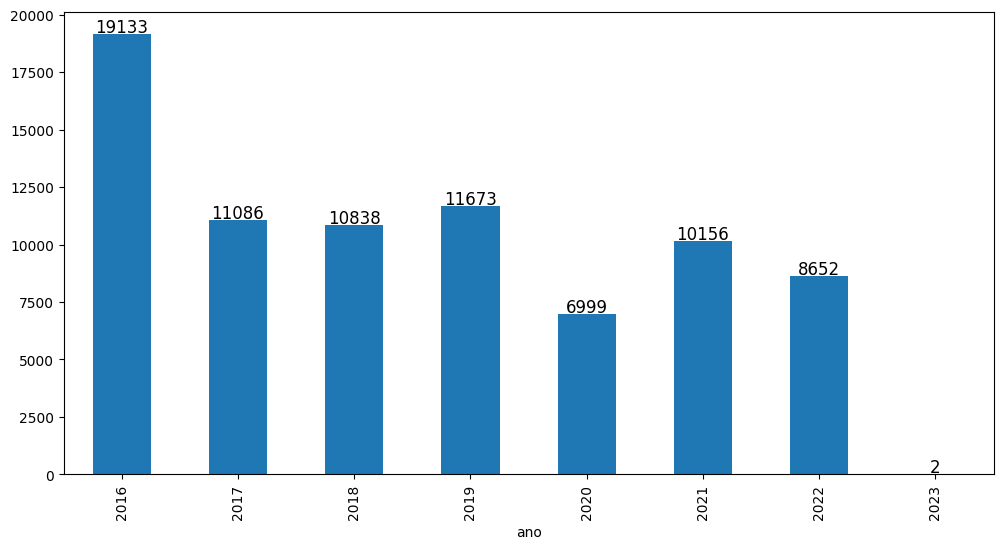

In [149]:
nuevas_consultas_por_anio = df_diagnosticos_tipo_consulta.groupby(["ano"])["nueva_consulta"].sum()
print(f"La cantidad de nuevas consultas por anio es:")

ax = nuevas_consultas_por_anio.plot(kind="bar")

# Adding values to the bars
for p in ax.patches:
    ax.annotate(
        f"{p.get_height()}",
        (p.get_x() + p.get_width() / 2.0, p.get_height()),
        ha="center",
        va="center",
        fontsize=12,
        color="black",
        xytext=(0, 5),
        textcoords="offset points",
    )

In [150]:
nuevas_consultas_por_anio_y_diag = (
    df_diagnosticos_tipo_consulta.groupby(["ano", "codigo_diagnostico"])["nueva_consulta"]
    .sum()
    .reset_index()
    .sort_values(["ano", "nueva_consulta"], ascending=False)
)

In [151]:
nuevas_consultas_por_anio_y_diag.to_csv("../data/interim/nuevas_consultas_por_especialidad.csv")

## 5. Obtención de procedimientos más frecuentes por unidad

La unidad de Hemodinamia es de alto interés para el Instituto Nacional del Tórax. Debido a lo anterior,
es necesario identificar cuales son los procedimientos realizados en esta especialidad.

Además, se quiere ver que exámenes son más frecuentes por cada una de las unidades del INT.

In [152]:
conteo_hemodinamia = df_procedimientos.query(
    "unidad_que_la_realiza == 'HEMODINAMÍA'"
).glosa.value_counts()

display(conteo_hemodinamia)

glosa
CINECORONARIOGRAFIA DERECHA Y/O IZQUIERDA (INCLUYE SONDEO CARDIACO IZQUIERDO Y VENTRICULOGRAFIA IZQUIERDA)                   1863
ANGIOPLASTIA INTRALUMINAL CORONARIA UNO O MULTIPLES VASOS (INCL. PROC. RAD; BALON, ROTABLATOR, STENT O SIMILAR)               778
AORTOGRAFIA, EN ADULTOS O NIÑOS (INCLUYE PROC. RAD.)                                                                          521
ANGIOPLASTIA INTRALUMINAL CORONARIA UNO O MULTIPLES VASOS - URGENCIA                                                          404
BIOPSIA ENDOMIOCARDICA (PROC. COMPLETO)                                                                                       234
ARTERIOGRAFIA SELECTIVA O SUPERSELECTIVA (PULMONAR, RENAL, TRONCO CELIACO, ETC) EN ADULTOS O NINOS (INCL. PROC. RAD.)         227
CINECORONARIOGRAFIA DERECHA Y/O IZQUIERDA - URGENCIA                                                                          216
SONDEO CARDIACO DERECHO C/S TERMODILUCION, EN ADULTOS O NIÑOS                       

En el resultado anterior se muestran todos los procedimientos de Hemodinamia realizado en el área
ambulatoria del Instituto Nacional del Tórax entre 2020 y 2022.

In [153]:
procedimientos_mas_frecuentes = df_procedimientos.groupby("unidad_que_la_realiza")[
    "glosa"
].value_counts().reset_index(name="cantidad_procedimientos")

In [154]:
display(procedimientos_mas_frecuentes)

,unidad_que_la_realiza,glosa,cantidad_procedimientos
0,ANATOMIA PATOLOGICA,ESTUDIO HISTOPATOLOGICO CON TECNICAS DE INMUNO...,2208
1,ANATOMIA PATOLOGICA,ESTUDIO HISTOPATOLOGICO DE BIOPSIA DIFERIDA (P...,1923
2,ANATOMIA PATOLOGICA,"CITODIAGNOSTICO CORRIENTE, EXFOLIATIVA (PAPANI...",1085
3,ANATOMIA PATOLOGICA,PCR TIEMPO REAL PARA MARCADORES TUMORALES EN C...,375
4,ANATOMIA PATOLOGICA,CELULAS NEOPLASICAS EN FLUIDOS BIOLOGICOS,75
...,...,...,...
124,IMAGENOLOGÍA,"ECOTOMOGRAFIA COMO APOYO A CIRUGIA, O A PROCED...",4
125,IMAGENOLOGÍA,"ECOGRAFÍA RENAL (BILATERAL), O DE BAZO",3
126,IMAGENOLOGÍA,"RADIOGRAFÍA DE TÓRAX, PROYECCIÓN COMPLEMENTARI...",2
127,IMAGENOLOGÍA,"ANGIOTOMOGRAFIA CORAZON, CON ESTUDIO DE VASOS ...",1


Los resultados indican los procedimientos más frecuentes por cada subunidad del INT. La tabla
se encuentra resumida.

A modo de ejemplo, Anatomía Patología realiza Estudios Histopatologicas con Técnicas de Inmunohistoquímica
como procedimiento más frecuente.

In [155]:
procedimientos_mas_frecuentes.to_excel(
    "../data/interim/procedimientos_mas_frecuentes.xlsx", index=False
)

## 5.1 Obtención de diagnósticos con la mayor cantidad de procedimientos de Broncoscopía

En este apartado se quiere responder la siguiente pregunta:

- ¿Cuáles son los diagnósticos más frecuentes que se realizan procedimientos de la unidad de
broncoscopía en el INT?

In [156]:
PROCEDIMIENTOS_BRONCO = procedimientos_mas_frecuentes.query(
    "unidad_que_la_realiza == 'BRONCOSCOPÍA'"
).glosa.unique()

In [157]:
canasta_diags_con_bronco = cantidad_proceds_por_pacientes[
    cantidad_proceds_por_pacientes["glosa"].isin(PROCEDIMIENTOS_BRONCO)
]

canasta_diags_con_bronco["glosa"] = canasta_diags_con_bronco["glosa"].str.strip()
canasta_diags_con_bronco = canasta_diags_con_bronco.sort_values(
    ["glosa", "cantidad_proced_por_pacientes", "cantidad_procedimientos"],
    ascending=[True, False, False],
)

In [158]:
canasta_diags_con_bronco.head(10)

,codigo_diagnostico,glosa,cantidad_procedimientos,cantidad_pacientes_distintos,cantidad_proced_por_pacientes,Código,Descripción,Categoría,Sección,Capítulo
109,45,BIOPSIA PULMONAR (CON AGUJA) NO INCLUYE LA RAD...,1,1,1.000000,NaN,NaN,NaN,NaN,NaN
125,62,BIOPSIA PULMONAR (CON AGUJA) NO INCLUYE LA RAD...,1,2,0.500000,NaN,NaN,NaN,NaN,NaN
3369,J938,BIOPSIA PULMONAR (CON AGUJA) NO INCLUYE LA RAD...,1,4,0.250000,J938,Otros neumotórax,J93 NEUMOTÓRAX,J90-J94 OTRAS ENFERMEDADES DE LA PLEURA,Cap.10 ENFERMEDADES DEL APARATO RESPIRATORIO ...
777,C64X,BIOPSIA PULMONAR (CON AGUJA) NO INCLUYE LA RAD...,1,7,0.142857,C64X,"Tumor maligno del riñón, excepto de la pelvis ...","C64 TUMOR MALIGNO DEL RIÑÓN, EXCEPTO DE LA PEL...",C64-C68 NEOPLASIAS MALIGNAS DE TRACTO URINARIO,Cap.02 NEOPLASIAS (C00-D49)
3925,R490,BIOPSIA PULMONAR (CON AGUJA) NO INCLUYE LA RAD...,1,7,0.142857,R490,Disfonía,R49 ALTERACIONES DE LA VOZ,R47-R49 SÍNTOMAS Y SIGNOS QUE AFECTAN AL HABL...,"Cap.18 SÍNTOMAS, SIGNOS Y RESULTADOS ANORMALE..."
3295,J851,BIOPSIA PULMONAR (CON AGUJA) NO INCLUYE LA RAD...,1,9,0.111111,J851,Absceso del pulmón con neumonía,J85 ABSCESO DEL PULMÓN Y DEL MEDIASTINO,J85-J86 ENFERMEDADES SUPURATIVAS Y NECRÓTICAS...,Cap.10 ENFERMEDADES DEL APARATO RESPIRATORIO ...
701,C413,BIOPSIA PULMONAR (CON AGUJA) NO INCLUYE LA RAD...,2,21,0.095238,C413,"Tumor maligno de la costilla, esternón y claví...",C41 TUMOR MALIGNO DE LOS HUESOS Y DE LOS CARTÍ...,C40-C41 NEOPLASIAS MALIGNAS DE HUESO Y DE CAR...,Cap.02 NEOPLASIAS (C00-D49)
3415,J961,BIOPSIA PULMONAR (CON AGUJA) NO INCLUYE LA RAD...,1,11,0.090909,J961,Insuficiencia respiratoria crónica,"J96 INSUFICIENCIA RESPIRATORIA, NO CLASIFICADA...",J96-J99 OTRAS ENFERMEDADES DEL APARATO RESPIR...,Cap.10 ENFERMEDADES DEL APARATO RESPIRATORIO ...
687,C39X,BIOPSIA PULMONAR (CON AGUJA) NO INCLUYE LA RAD...,1,12,0.083333,C39X,Tumor maligno de otros sitios y de los mal def...,C39 TUMOR MALIGNO DE OTROS SITIOS Y DE LOS MAL...,C30-C39 NEOPLASIAS MALIGNAS DE ÓRGANOS RESPIR...,Cap.02 NEOPLASIAS (C00-D49)
975,D382,BIOPSIA PULMONAR (CON AGUJA) NO INCLUYE LA RAD...,1,13,0.076923,D382,Tumor de comportamiento incierto o desconocido...,D38 TUMOR DE COMPORTAMIENTO INCIERTO O DESCONO...,D37-D48 NEOPLASIAS DE COMPORTAMIENTO INCIERTO...,Cap.02 NEOPLASIAS (C00-D49)


In [159]:
canasta_diags_con_bronco.to_excel(
    "../data/interim/diags_con_procedimientos_de_bronco.xlsx", index=False
)